In [1]:
import sys
sys.path.insert(1, '../scripts/')

import os
import csv
import requests
import nbm_funcs
import matplotlib

import numpy as np
import pandas as pd
import xarray as xr
import multiprocessing as mp

import seaborn as sns
import scipy.stats as scipy
import urllib.request as req
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

os.environ["OMP_NUM_THREADS"] = "1"

***
***
# Configuration
Select 'site' to evaluate, modify 'vsite' if an alternate verification site is preferred<br>
Fixed 'date0' at the start of the NBM v3.2 period (2/20/2020)<br>
Full lead time is 263 hours - Note if date1 is within this period, there will be missing verification data as it does not exist yet!

In [9]:
# NBM 1D Viewer Site to use
site = nbm_funcs._site = 'KSFO'

# Data Range
lead_time_end = 180
init_hours = nbm_funcs._init_hours = [13]#[1, 7, 13, 19]

date0 = nbm_funcs._date0 = datetime(2020, 5, 19)#3, 1)
date1 = nbm_funcs._date1 = datetime(2020, 9, 15)#today

In [10]:
# datadir = nbm_funcs._datadir = '../archive/%s/data/'%site
datadir = nbm_funcs._datadir = '../archive/data/'
os.makedirs(datadir, exist_ok=True)

dates = nbm_funcs._dates = pd.date_range(date0, date1, freq='1D')
date2 = nbm_funcs._date2 = date1 + timedelta(hours=lead_time_end)

print(('\nForecast Site: {}\nInit Hours: '+
      '{}\nFirst Init: {}\nLast Init: {}\nLast Verif: {}').format(
    site, init_hours, date0, date1, date2))


Forecast Site: KSFO
Init Hours: [13]
First Init: 2020-05-19 00:00:00
Last Init: 2020-09-15 00:00:00
Last Verif: 2020-09-22 12:00:00


***
***
# Obtain observation data from SynopticLabs (MesoWest) API
These are quality-controlled precipitation observations with adjustable accumulation periods<br>
See more at: https://developers.synopticdata.com/mesonet/v2/stations/precipitation/
<br><br>
If no observation file exists, will download and save for future use

In [11]:
# Get metadata for the select point
meta_base = 'https://api.synopticdata.com/v2/stations/metadata?'
api_token = '&token=a2386b75ecbc4c2784db1270695dde73'
meta_site = '&stid=%s&complete=1'%site
url = meta_base + api_token + meta_site
# print(url)

site_meta_raw = requests.get(url).json()
# print(meta_raw['STATION'][0])

zone = site_meta_raw['STATION'][0]['NWSZONE']
cwa = site_meta_raw['STATION'][0]['CWA']

print('Site: %s\nCWA: %s\nZone: %s'%(site, cwa, zone))

Site: KSFO
CWA: MTR
Zone: CA508


In [12]:
# Get a list of sites in the CWA that report precip
precip_base = 'https://api.synopticdata.com/v2/stations/precip?&complete=1&interval=6'
zone_query = '&nwszone=%s'%zone
cwa_query = '&cwa=%s'%cwa
date_query = '&start=%s&end=%s'%(
    date0.strftime('%Y%m%d%H%M'),
    (date0+timedelta(hours=6)).strftime('%Y%m%d%H%M'))

# We could query for a list of relevant zones within a CWA here
# Then pass a list of zones to the zone query
# !Add later!

# Fix this later! Temp fix to expand the zone for more NWS/FAA/RAWS stations
# Due to 1D Viewer file limitation - Ask Chad for advice?
zone_query = cwa_query

url = precip_base + api_token + zone_query + date_query
zone_meta_raw = requests.get(url).json()

meta = []
for station in zone_meta_raw['STATION']:
    
#     We need to get back to a zone query - for now this will work with a CWA query to only hit sites that exist within a CWA    
    if (('NWS' in station['SHORTNAME']) | ('RAWS' in station['SHORTNAME']) & (station['STID'][0] == 'K')):
        meta.append({k:station[k] for k in station.keys() if type(station[k]) == str})
        
meta = pd.DataFrame(meta).set_index('STID')

meta.shape

(16, 18)

In [13]:
for k in meta:
    try:
        meta[k] = meta[k].astype(float)
    except:
        pass

meta

,NWSFIREZONE,ELEV_DEM,TIMEZONE,SGID,SHORTNAME,ELEVATION,GACC,STATUS,LONGITUDE,COUNTY,STATE,CWA,NWSZONE,ID,MNET_ID,NAME,COUNTRY,LATITUDE
STID,,,,,,,,,,,,,,,,,,
KAPC,MTR506,19.7,America/Los_Angeles,NC02,NWS/FAA,33.0,NOCC,ACTIVE,-122.27944,Napa,CA,MTR,CA506,92.0,1.0,"Napa, Napa County Airport",US,38.20750
KCCR,MTR510,9.8,America/Los_Angeles,NC03B,NWS/FAA,23.0,NOCC,ACTIVE,-122.05194,Contra Costa,CA,MTR,CA510,127.0,1.0,"Concord, Buchanan Field",US,37.99167
KHWD,MTR508,26.2,America/Los_Angeles,NC03A,NWS/FAA,46.0,NOCC,ACTIVE,-122.11833,Alameda,CA,MTR,CA508,223.0,1.0,"Hayward, Hayward Air Terminal",US,37.66083
KLVK,MTR510,387.1,America/Los_Angeles,NC03B,NWS/FAA,397.0,NOCC,ACTIVE,-121.81444,Alameda,CA,MTR,CA510,254.0,1.0,"Livermore, Livermore Municipal Airport",US,37.69278
KMRY,MTR530,170.6,America/Los_Angeles,SC07,NWS/FAA,167.0,SOCC,ACTIVE,-121.84875,Monterey,CA,MTR,CA530,276.0,1.0,Monterey Regional Airport,US,36.59047
KOAK,MTR508,-9.8,America/Los_Angeles,NC03A,NWS/FAA,3.0,NOCC,ACTIVE,-122.23294,Alameda,CA,MTR,CA508,305.0,1.0,"Oakland, Metro Oakland International Airport",US,37.71780
KSFO,MTR508,0.0,America/Los_Angeles,NC03A,NWS/FAA,10.0,NOCC,ACTIVE,-122.36558,San Mateo,CA,MTR,CA508,379.0,1.0,"San Francisco, San Francisco International Air...",US,37.61961
KSJC,MTR513,39.4,America/Los_Angeles,NC03A,NWS/FAA,59.0,NOCC,ACTIVE,-121.92417,Santa Clara,CA,MTR,CA513,384.0,1.0,"San Jose, San Jose International Airport",US,37.35917
KSNS,MTR528,45.9,America/Los_Angeles,SC07,NWS/FAA,82.0,SOCC,ACTIVE,-121.60806,Monterey,CA,MTR,CA528,397.0,1.0,"Salinas, Salinas Municipal Airport",US,36.66361


<hr><hr>

## Plot a map of the stations, color by elevation, marker by network

In [14]:
import geopandas as gpd
from glob import glob

geodir = '../forecast-zones/'
zones_shapefile = glob(geodir + '*.shp')[0]

# Read the shapefile
zones = gpd.read_file(zones_shapefile)
# Prune to Western Region using TZ
zones = zones.set_index('TIME_ZONE').loc[['M', 'Mm', 'm', 'MP', 'P']].reset_index()
zones = zones[zones['CWA'] == cwa]

# zones.to_file(geodir + 'forecast-zones.json', driver = 'GeoJSON')
zones

,TIME_ZONE,STATE,CWA,FE_AREA,ZONE,NAME,STATE_ZONE,LON,LAT,SHORTNAME,InPoly_FID,SimPgnFlag,MaxSimpTol,MinSimpTol,geometry
497,P,CA,MTR,ww,516,Southern Salinas Valley/Arroyo Seco and Lake S...,CA516,-121.0546,36.1014,Southern Salinas Valley/Arroyo S,2315,0,0.0001,0.0001,"POLYGON ((-121.27280 36.38591, -121.22760 36.3..."
498,P,CA,MTR,ww,517,Santa Lucia Mountains and Los Padres National ...,CA517,-121.4188,36.1606,Santa Lucia Mountains and Los Pa,2316,0,0.0001,0.0001,"POLYGON ((-121.55550 36.53821, -121.51700 36.4..."
509,P,CA,MTR,ww,513,Santa Clara Valley Including San Jose,CA513,-121.7971,37.2196,Santa Clara Valley Including San,2329,0,0.0001,0.0001,"POLYGON ((-121.73620 37.23751, -121.71280 37.2..."
538,P,CA,MTR,ww,530,Southern Monterey Bay and Big Sur Coast,CA530,-121.7566,36.6165,Southern Monterey Bay and Big Su,2676,0,0.0001,0.0001,"MULTIPOLYGON (((-121.45331 35.87534, -121.4537..."
539,P,CA,MTR,ww,529,Northern Monterey Bay,CA529,-121.9005,36.9757,Northern Monterey Bay,2708,0,0.0001,0.0001,"POLYGON ((-121.86000 37.02501, -121.84330 37.0..."
555,P,CA,MTR,ww,518,Mountains Of San Benito County And Interior Mo...,CA518,-120.9214,36.3718,Mountains Of San Benito County A,2834,0,0.0001,0.0001,"POLYGON ((-121.22300 36.91341, -121.22130 36.9..."
556,P,CA,MTR,ww,528,Northern Salinas Valley/Hollister Valley and C...,CA528,-121.5047,36.6769,Northern Salinas Valley/Holliste,2835,0,0.0001,0.0001,"POLYGON ((-121.43670 36.97811, -121.43439 36.9..."
557,P,CA,MTR,ww,512,Santa Cruz Mountains,CA512,-122.0400,37.1726,Santa Cruz Mountains,2836,0,0.0001,0.0001,"POLYGON ((-122.23309 37.37301, -122.20090 37.3..."
558,P,CA,MTR,ww,509,San Francisco Peninsula Coast,CA509,-122.3923,37.3740,San Fransisco Peninsula Coast,2837,0,0.0001,0.0001,"MULTIPOLYGON (((-122.33810 37.10971, -122.3376..."
559,P,CA,MTR,ww,507,North Bay Mountains,CA507,-122.6939,38.5515,North Bay Mountains,2838,0,0.0001,0.0001,"MULTIPOLYGON (((-122.35190 38.83631, -122.3488..."


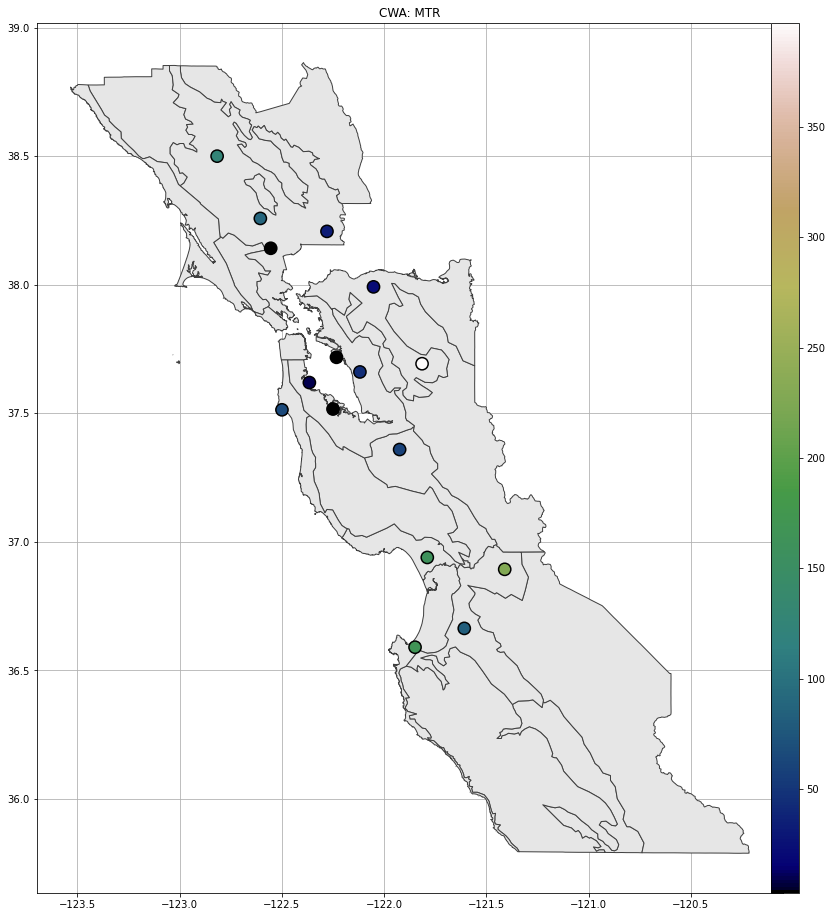

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, figsize=(16, 16), facecolor='w')
ax.set_title('CWA: %s'%cwa)

zones.plot(column='NAME', color='0.9', edgecolor='0.25', ax=ax, zorder=10)

cbd = ax.scatter(meta['LONGITUDE'], meta['LATITUDE'], c=meta['ELEVATION'], cmap='gist_earth', 
                 s=150, marker='o', edgecolor='k', linewidth=1.5, zorder=20,)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=-1.5)
plt.colorbar(cbd, cax=cax)
ax.grid(True, zorder=-10)

# ax.set_ylim(bottom=46.30, top=49.10)
# ax.set_xlim(left=-124.9, right=-120.6)

fig.show()

<hr><hr>

In [ ]:
# Single-process
ob_files = [nbm_funcs.get_precip_obs_mp(i) for i in meta.index.values]
ob_files = [f for f in ob_files if f is not None]

# Multi-process (needs fixing...)
# with mp.get_context('fork').Pool(mp.cpu_count()) as p:    
#     ob_files = p.map_async(nbm_funcs.get_precip_obs_mp, meta.index.values, chunksize=1)
#     ob_files.wait()
# ob_files = [f for f in ob_files.get() if f is not None]

obs = []
for file in ob_files:
    site = file.split('/')[-1].split('_')[0]
    iobs = pd.read_pickle(file)
    iobs['Site'] = np.full(iobs.index.size, fill_value=site, dtype='U10')
    iobs = iobs.reset_index().set_index(['ValidTime', 'Site'])
    obs.append(iobs)
    
obs = pd.concat(obs).sort_index()

mm_in = 1/25.4
obs *= mm_in
[obs.rename(columns={k:k.replace('mm', 'in')}, inplace=True) for k in obs.keys()]

# OPTIONAL! Drop NaN rows... may help elim lower qual dataw
# obs = obs.dropna(how='all')

sites = np.unique(obs.index.get_level_values(1))
print(sites)

print(obs.shape)
obs.head(10)

In [ ]:
obs.describe().T

***
***
# Obtain NBM forecast data from NBM 1D Viewer (csv file API)
These are the NBM 1D output files extracted from the viewer with 3 set accumulation periods<br>
See more at: https://hwp-viz.gsd.esrl.noaa.gov/wave1d/?location=KSLC&col=2&hgt=1&obs=true&fontsize=1&selectedgroup=Default
<br><br>
If no forecast file exists, will download and save for future use. This can take some time.

In [ ]:
# nbm_files = [nbm_funcs.get_nbm_1d_mp(i) for i in meta.index]
# nbm_files = [f for f in nbm_files if f is not None]

with mp.get_context('fork').Pool(mp.cpu_count()) as p:    
    nbm_files = p.map_async(nbm_funcs.get_nbm_1d_mp, meta.index, chunksize=1)
    nbm_files.wait()  
nbm_files = [f for f in nbm_files.get() if f is not None]

nbm = []
for file in nbm_files:
    site = file.split('/')[-1].split('_')[0]
    inbm = pd.read_pickle(file)
    inbm['Site'] = np.full(inbm.index.size, fill_value=site, dtype='U10')
    inbm = inbm.reset_index().set_index(['InitTime', 'ValidTime', 'Site'])
    nbm.append(inbm)
    
nbm = pd.concat(nbm).sort_index()
nbm

# Convert mm to in
for k in nbm.keys():
    if 'prob' not in k:
        nbm[k] *= mm_in

lead = [row[1]-row[0] for row in nbm.index]
lead = np.array([1 + row.days*24 + (row.seconds/3600) for row in lead], dtype=int)
nbm.insert(0, 'LeadTime', lead)

# Nix values where lead time shorter than acc interval
for k in [k for k in nbm.keys() if k != 'LeadTime']:
    if 'APCP24hr' in k:
        nbm[k][nbm['LeadTime'] < 24] = np.nan
    elif 'APCP12hr' in k:
        nbm[k][nbm['LeadTime'] < 12] = np.nan
    elif 'APCP6r' in k:
        nbm[k][nbm['LeadTime'] < 6] = np.nan
    else:
        pass
    
nbm = nbm.dropna(subset=[k for k in nbm.keys() if k != 'LeadTime'], how='all')
nbm[25:50]

In [ ]:
# Display some basic stats
nbm.loc[:, ['APCP6hr_surface', 'APCP6hr_surface_70% level', 'APCP6hr_surface_50% level',
            'APCP12hr_surface', 'APCP12hr_surface_70% level', 'APCP12hr_surface_50% level',
            'APCP24hr_surface', 'APCP24hr_surface_70% level', 'APCP24hr_surface_50% level',
            'APCP24hr_surface_prob >0.254',
            ]].describe().T

#### Plot the distribution of precipitation observations vs forecasts for assessment of representativeness

In [ ]:
# Label fix:
site = nbm_funcs._site = zone_query.replace('&', '').replace('=', '_').upper()

figdir = nbm_funcs._figdir = '../archive//%s/figures/'%site
os.makedirs(figdir, exist_ok=True)

In [ ]:
thresh_id = nbm_funcs._thresh_id = {'Small':[0, 1], 'Medium':[1, 2], 'Large':[2, 3], 'All':[0, 3]}

# 33rd, 67th percentile determined above
thresholds = nbm_funcs._thresholds = {interval:nbm_funcs.apcp_dist_plot(obs, nbm, interval, trimZero=False, show=True) 
              for interval in [6, 12, 24]}

thresholds

In [ ]:
# Force Override
nbm_funcs._thresholds = thresholds = {
    6:  np.array([0., 0.10, 0.25, np.inf]),
    12: np.array([0., 0.10, 0.5, np.inf]),
    24: np.array([0., 0.5, 2.0, np.inf]),}

***
***
# Reorganize the data for analysis:
#### Isolate the forecasts by accumulation interval and lead time

In [ ]:
plist = np.arange(1, 100)

# matchfile = datadir + 'matched/CWA_%s_%s_%s_verifMatched.NPremoved.pd'%(
matchfile = datadir + 'matched/CWA_%s_%s_%s_verifMatched.pd'%(
    cwa, date0.strftime('%Y%m%d'), date1.strftime('%Y%m%d'))

if os.path.isfile(matchfile):
    data = pd.read_pickle(matchfile)

else:
    
    os.makedirs('/'.join(matchfile.split('/')[:-1]), exist_ok=True)
    
    data = []
    for interval in [24]:

        pkeys = np.array([k for k in nbm.keys() if '%dhr_'%interval in k])
        pkeys = np.array([k for k in pkeys if '%' in k])
        pkeys = pkeys[np.argsort([int(k.split('_')[-1].split('%')[0]) for k in pkeys])]

        for lead_time in np.arange(interval, lead_time_end, 6):

            for esize in ['Small', 'Medium', 'Large', 'NP']:

                try:
                    thresh = [thresholds[interval][thresh_id[esize][0]], 
                              thresholds[interval][thresh_id[esize][1]]]
                except:
                    thresh = [0, 0]

                print('\rProcessing interval %d lead %dh'%(interval, lead_time), end='')

                # We need to break out the verification to each lead time,
                # but within each lead time we have a number of valid times.
                # At each lead time, valid time, isolate the forecast verification

                # Combine the datasets to make it easier to work with
                idata = nbm[nbm['LeadTime'] == lead_time].merge(obs, on=['ValidTime', 'Site']).drop(columns='LeadTime')

                # Subset for event size using the observed precip
                iobs = idata['%dh_precip_in'%interval]
                #iobs = iobs.replace(np.nan, 0.) if 'NPremoved' in matchfile else iobs

                # Do the trimming of the selected dataset
                if esize != 'NP':
                    idata = idata[((iobs >= thresh[0]) & (iobs < thresh[1]))]
                else:
                    idata = idata[iobs == 0]

                del iobs

                idata['%dh_precip_in'%interval] = (idata['%dh_precip_in'%interval]#.replace(np.nan, 0) 
                    if 'NPremoved' in matchfile else idata['%dh_precip_in'%interval])

                for itime in idata.index:

                    try:
                        prob_fx = idata.loc[itime, pkeys]
                        mean_fx = np.nanmean(prob_fx)
                        std_fx = np.nanstd(prob_fx)
                        med_fx = idata.loc[itime, 'APCP%dhr_surface_50%% level'%interval]
                        det_fx = idata.loc[itime, 'APCP%dhr_surface'%interval]
                        
                        pop_fx = idata.loc[itime, 'APCP%dhr_surface_prob >0.254'%interval]
                                                
                        # Optional - leave as nan?
                        det_fx = det_fx if ~np.isnan(det_fx) else 0.

                        verif_ob = idata.loc[itime, '%dh_precip_in'%interval]

                        verif_rank = np.searchsorted(prob_fx, verif_ob, 'right')                    
                        verif_rank_val = prob_fx[verif_rank-1]
                        verif_rank_error = verif_rank_val - verif_ob

                        verif_rank = 101 if ((verif_rank >= 99) & (verif_ob > verif_rank_val)) else verif_rank
                        verif_rank = -1 if ((verif_rank <= 1) & (verif_ob < verif_rank_val)) else verif_rank

                        det_rank = np.searchsorted(prob_fx, det_fx, 'right')
                        det_error = det_fx - verif_ob

                    except:
                        pass
                        # print('failed', itime)

                    else:
                        if ~np.isnan(verif_rank_val):

                            data.append([
                                # Indexers
                                interval, lead_time, itime[0], itime[1], esize,

                                # Verification and deterministic
                                verif_ob, det_fx, det_rank, det_error,

                                # Probabilistic
                                verif_rank, verif_rank_val, verif_rank_error, 
                                med_fx, mean_fx, std_fx, pop_fx])

    data = pd.DataFrame(data, columns=['Interval', 'LeadTime', 'ValidTime', 'Site', 'EventSize',
                    'verif_ob', 'det_fx', 'det_rank', 'det_error',
                    'verif_rank', 'verif_rank_val', 'verif_rank_error', 
                    'med_fx', 'mean_fx', 'std_fx', 'pop'])

    data.to_pickle(matchfile)
    
print('\n\nAvailable keys:\n\t\t{}\nn rows: {}\n'.format('\n\t\t'.join(data.keys()), len(data)))

data

In [ ]:
print(cwa)
data[data['EventSize'] == 'Large'].describe().T

In [ ]:
print('NPEs')

fig = plt.figure(facecolor='w', figsize=(10, 6))

plt.hist(data[(data['EventSize'] == 'NP')&(data['det_fx'] > 0.1)]['det_fx'], bins=np.arange(0.01, 2.1, .01), edgecolor='k')

# plt.ylim(top=800)
plt.xlim(left=0)
plt.grid()
plt.title('CWA: %s\nNon-Precipitating Forecast Events\n%s'%(cwa, ''))

plt.show()

data[((data['EventSize'] == 'NP') & (data['det_fx'] > 0.01))][['det_fx']].describe().T

***
***
# Create Bulk Temporal Stats Plots
#### Reliability diagrams, bias over time, rank over time, etc.

In [ ]:
plot_type = 'Verification'
plot_var = 'verif_rank'

for esize in ['All', 'Small', 'Medium', 'Large']:
    for interval in [24]: #[6, 12, 24]:
        for short, long in zip([0], [108]): #zip([0, 48, 108], [48, 108, 180]):

            kwargs = {'_interval':interval, '_esize':esize,
                     '_short':short, '_long':long,
                     '_plot_type':plot_type, '_plot_var':plot_var}
            
            try:
                nbm_funcs.histograms_verif_rank(data, **kwargs, show=True)
            except:
                pass

#### Plot a reliability diagram style CDF to evaluate percentile rankings

In [ ]:
short, long = 0, 120
plot_type = 'Verification'
plot_var = 'verif_rank'
esize = 'All'

for esize in ['All', 'Small', 'Medium', 'Large']:
    for interval in [24]: #[6, 12, 24]:
        for short, long in zip([0], [108]): #zip([0, 48, 108], [48, 108, 180]):
        
                kwargs = {'_interval':interval, '_esize':esize,
                         '_short':short, '_long':long,
                         '_plot_type':plot_type, '_plot_var':plot_var}

                #nbm_funcs.reliability_verif_cdf_multistation(data, **kwargs, show=True)

#### Produce bias, ME, MAE, and percentile rank plots as they evolve over time
This helps illustrate at what leads a dry/wet bias may exist and how severe it may be<br>
Adds value in interpreting the CDF reliability diagrams

In [ ]:
# short, long = 0, 120
# esize = 'All'

# for interval in [6, 12, 24]:

#     kwargs = {'_interval':interval, '_esize':esize,
#              '_short':short, '_long':long}

#     nbm_funcs.rank_over_leadtime(data, **kwargs, show=True)

## Create PODs/traditional metrics

In [ ]:
esize = 'All'

verif_on = 'det_fx' #det_fx

for interval in [24]:
    for short, long in zip([0, 48, 108], [48, 108, 180]):

        select = data[((data['Interval'] == interval)
                        & ((data['LeadTime'] > short) 
                        & (data['LeadTime'] <= long)))]

        select = select[select['EventSize'] == esize] if esize != 'All' else select

#         select = select[(select['verif_ob'] > 0.05) & (select['det_fx'] > 0.05)]
        
        maxval = max(max(select['verif_ob']), max(select[verif_on]))
        bins = np.linspace(0.001, maxval, 20)


        scatter2d = []
        for i, v in enumerate(bins):
            v0 = bins[i-1] if i > 0 else 0

            vf = select[(select[verif_on] > v0) & (select[verif_on] <= v)]['verif_ob']
            vf = vf.median() if vf.size >= 10 else np.nan

            vo = select[(select['verif_ob'] > v0) & (select['verif_ob'] <= v)][verif_on]
            vo = vo.median() if vo.size >= 10 else np.nan

            scatter2d.append((np.nanmean([v0, v]), vf, vo))
        scatter2d = np.array(scatter2d)


        fig, ax = plt.subplots(1, figsize=(8, 7), facecolor='w')

        cbd = ax.hist2d(select['verif_ob'], select[verif_on], density=False, bins=[bins, bins], cmap='coolwarm', norm=matplotlib.colors.LogNorm(), zorder=10)
        ax.plot(np.arange(0, maxval*2), 'k-', linewidth=0.5, zorder=11)

        ax.set_xticks(bins[::2])
        ax.set_xticklabels(['%.2f'%b for b in bins[::2]], rotation=45)

        ax.set_yticks(bins[::2])
        ax.set_yticklabels(['%.2f'%b for b in bins[::2]], rotation=0)

        ax.grid(zorder=-1)

        vxy = scatter2d[:, 0]
        vf = scatter2d[:, 1]
        vo = scatter2d[:, 2]

        ax.scatter(vf, vxy, zorder=20, c='b', label='Median Forecast Event Size')
        ax.scatter(vxy, vo, zorder=20, c='r', label='Median Observed Event Size')

        ax.set_xlabel('Forecast Event Size (in)')
        ax.set_ylabel('Observed Event Size (in)')

        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

        plt.colorbar(cbd[3], ax=ax, label='Frequency of Event')

        n_precip_periods = np.unique(select['ValidTime'][~np.isnan(select['verif_ob'])]).shape[0]

        ax.set_title(('{} Bivariate Histograms\nNBM v3.2 {} – {}\n\n' + 
                      'Interval: {} h | Lead Time: {} – {} h\nn={}, np={}\n').format(
                    site, date0.strftime('%Y-%m-%d'), date1.strftime('%Y-%m-%d'),
                    interval, short, long, len(select), n_precip_periods), size=14)

In [ ]:
verif_on = 'det_fx'

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

for interval in [24]:
    for short, long in zip([0, 48, 108], [48, 108, 180]):

        esize = 'All'

        select = data[((data['Interval'] == interval)
                        & ((data['LeadTime'] > short) 
                        & (data['LeadTime'] <= long)))]

        select = select[select['EventSize'] == esize] if esize != 'All' else select

        # select = select[(select['verif_ob'] > 0) & (select['det_fx'] > 0)]

        bins = np.linspace(0.001, maxval, 20)

        bias_ratio = []
        for i, v in enumerate(bins):

            v0 = bins[i-1] if i > 0 else 0
            vf = select[(select[verif_on] > v0) & (select[verif_on] <= v)]['verif_ob']
            vf = vf[vf > 0]
            vo = select[(select['verif_ob'] > v0) & (select['verif_ob'] <= v)][verif_on]
            vo = vo[vo > 0]

            try:
                br = vf.size/vo.size
            except:
                pass
            else:
                br = np.nan if br == 0 else br
                bias_ratio.append((np.nanmean([v0, v]), br))

        bias_ratio = np.array(bias_ratio)

        fig, ax = plt.subplots(1, figsize=(12, 6), facecolor='w')

        ax.plot(bias_ratio[:, 0], bias_ratio[:, 1], 'k-o')
        ax.axhline(1, c='k', linewidth=1.2)

        yx = np.nanmax(bias_ratio[:, 1])
        yx = np.ceil(yx * 1.1)

        yn = np.nanmin(bias_ratio[:, 1])
        yn = np.floor(yn * 0.9)

        ax.fill_between(bins, 1.2, yx, color='green', alpha=0.25)
        ax.fill_between(bins, yn, 0.8, color='orange', alpha=0.4)

        ax.set_xticks(bins)
        ax.set_xticklabels(['%.2f'%b for b in bins], rotation=45)

        # ax.set_yticks(np.arange(yn, yx, .2))

        ax.set_xlim([0, bins[-1]])
        ax.set_ylim([yn, yx])

        ax.set_xlabel('Event Size Bin (in)')
        ax.set_ylabel('Frequency Bias')

        axi = inset_axes(ax, width="200%", height="200%",
                           bbox_to_anchor=(.8, .8, .15, .1),
                           bbox_transform=ax.transAxes, loc=1)

        axi.hist(select['verif_ob'][select['verif_ob'] > 0], bins=bins, color='k', width=0.04)

        ax.set_xlim(right=bins[-1])
        axi.set_yscale('log')
        axi.set_ylim(top=15e3)
        axi.set_yticks([1e1, 1e2, 1e3, 1e4])

        axi.set_xlabel('Precip Bin (in)')
        axi.set_ylabel('# Obs')
        axi.grid(True)
        
        ax.set_title(('{} Bias Ratio ({})\nNBM v3.2 {} – {}\n\n' + 
              'Interval: {} h | Lead Time: {} – {} h\nn={}, np={}\n').format(
            site, verif_on, date0.strftime('%Y-%m-%d'), date1.strftime('%Y-%m-%d'),
            interval, short, long, len(select), n_precip_periods), size=14)

        ax.grid()

In [ ]:
probkeys = ['APCP6hr_surface_prob >0.254', 'APCP12hr_surface_prob >0.254', 
    'APCP24hr_surface_prob >0.254', 'APCP24hr_surface_prob >2.54',
    'APCP24hr_surface_prob >6.35', 'APCP24hr_surface_prob >12.7',
    'APCP24hr_surface_prob >25.4', 'APCP24hr_surface_prob >50.8',
    'APCP24hr_surface_prob >76.2', 'APCP24hr_surface_prob >101.6',
    'APCP24hr_surface_prob >127', 'APCP24hr_surface_prob >152.4']

probkeys_in = [k.replace(k.split('>')[1], str(np.ceil(float(k.split('>')[1])*100*mm_in)/100)) for k in probkeys]
probkeys.append('LeadTime')

for short, long in zip([0], [48]):
    for interval in [24]:
        
        prob = nbm.loc[:, probkeys].rename(columns={k:nk for k, nk in zip(probkeys, probkeys_in)}
                                              ).reset_index().set_index(['ValidTime', 'Site']).drop(columns='InitTime')

        prob = prob[(prob['LeadTime'] > short) & (prob['LeadTime'] <= long)]

        prob = obs[['%dh_precip_in'%interval]].join(prob, on=['ValidTime', 'Site'])
        prob[prob.duplicated(keep='first')]

        prob['%dh_precip_in'%interval] = prob['%dh_precip_in'%interval]#.replace(np.nan, 0)
        prob = prob[~np.isnan(prob['%dh_precip_in'%interval])].dropna(how='any')

        N = prob.shape[0]
        print('N:', N)

        for reli_thresh in [0.01, 0.1, 0.25, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]:
        
            try:

                bins = np.arange(0, 101, 5)

                K = len(bins)
                o_bar = prob[prob['%dh_precip_in'%interval] > reli_thresh].size/N

                reliplot = []
                fcast_hist = []
                for i, p in enumerate(bins):
                    p0, p1 = p-0.025, p+0.025

                    pi = prob[(prob['APCP%dhr_surface_prob >%s'%(interval, reli_thresh)] > p0) & 
                                  (prob['APCP%dhr_surface_prob >%s'%(interval, reli_thresh)] <= p1)]

                    nk = pi.shape[0]
                    fcast_hist.append([p, nk])
                    
                    ok_bar = (pi[pi['%dh_precip_in'%interval] > reli_thresh].shape[0]/nk) * 100

                    reliplot.append([p/100, ok_bar/100])

                reliplot = np.array(reliplot)
                fcast_hist = np.array(fcast_hist)
                
                fig, ax = plt.subplots(figsize=(10, 10), facecolor='w')

                fcast_prob = reliplot[:, 0]
                obs_freq = reliplot[:, 1]

                perf = np.arange(0, 1.1, .1)
                climo = o_bar/100
                skill = perf - ((perf - climo)/2)

                ax.plot(fcast_prob, obs_freq, 
                        color='r', linewidth=2,
                        marker='+', markersize=15)

                ax.plot(perf, perf, 
                        color='k')

                ax.axhline(climo, 
                        color='k', linestyle='--')

                ax.plot(perf, skill, 
                        color='k', linestyle='--')

                try:
                    focal = np.arange(0, 1, 0.0001)[np.where(
                        np.arange(0, 1, 0.0001) == round(climo, 3))][0]

                    fillperf = np.arange(focal, 1, .001)
                    ax.fill_between(fillperf, fillperf - (fillperf - climo)/2, 1,
                            color='gray', alpha=0.35)

                    fillperf = np.arange(0, focal, .001)
                    ax.fill_between(fillperf, 0, fillperf - (fillperf - climo)/2,
                            color='gray', alpha=0.35)
                except:
                    fillperf = np.arange(0, 1, .001)
                    ax.fill_between(fillperf, fillperf - (fillperf - climo)/2, 1,
                            color='gray', alpha=0.35)

                ax.set_xlim([0, 1])
                ax.set_ylim([0, 1])

                ax.set_xticks(perf)
                ax.set_yticks(perf)
                
                ax.set_xlabel('Forecast Probability')
                ax.set_ylabel('Observed Relative Frequency')

                ax.grid(zorder=1)

                ax.set_title(('{} Reliability Diagram\nNBM v3.2 {} – {}\n\n' + 
                              'Interval: {} h | Lead Time: {} – {} h\nn={}, np={}\n\n' + 
                              'POP > {:.2f}').format(
                            site, date0.strftime('%Y-%m-%d'), date1.strftime('%Y-%m-%d'),
                            interval, short, long, len(select), n_precip_periods, reli_thresh), size=14)

                plt.show()
                
                fig, ax = plt.subplots(figsize=(10.135, 2), facecolor='w')
                ax.bar(fcast_hist[:, 0], fcast_hist[:, 1], color='k', width=3)
                
                ax.set_yscale('log')
                ax.set_yticks([1e1, 1e2, 1e3, 1e4])
                
                ax.set_xlabel('Forecast Probability')
                ax.set_ylabel('# Forecasts')
                
                ax.grid()
                plt.show()
                
                print('\n\n')

            except:
                pass